In [2]:
import datetime
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer
from nltk.util import ngrams
import spacy
import re

In [3]:
# Load Data
train = pd.read_csv('../public_data/train/track_a/eng.csv')
val = pd.read_csv('../public_data/dev/track_a/eng_a.csv')
emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

train.describe()

,Anger,Fear,Joy,Sadness,Surprise
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,0.120303,0.582009,0.243497,0.317197,0.303107
std,0.325375,0.493318,0.429270,0.465469,0.459684
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2768 non-null   object
 1   text      2768 non-null   object
 2   Anger     2768 non-null   int64 
 3   Fear      2768 non-null   int64 
 4   Joy       2768 non-null   int64 
 5   Sadness   2768 non-null   int64 
 6   Surprise  2768 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 151.5+ KB


In [5]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        116 non-null    object 
 1   text      116 non-null    object 
 2   Anger     0 non-null      float64
 3   Fear      0 non-null      float64
 4   Joy       0 non-null      float64
 5   Sadness   0 non-null      float64
 6   Surprise  0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 6.5+ KB


In [6]:
# Preprocessing Config
config = {'sep_pn': True, 'rm_pn': False, 'apply_lemmatization': True, 'apply_stemming': True, 'add_bigrams': True, 'rm_sw': False}

# Preprocessing Functions
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")

In [7]:
def pre_process(text, config):
    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

# Preprocess and Extract Features
vectorizer = CountVectorizer()

train_text = [pre_process(text, config) for text in train["text"]]
val_text = [pre_process(text, config) for text in val["text"]]

X_train = vectorizer.fit_transform(train_text).toarray()
X_val = vectorizer.transform(val_text).toarray()

# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])

# POS Encoding
max_length = max(max(len(tags) for tags in train_pos_tags), max(len(tags) for tags in val_pos_tags))
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)

# Combine Features
combined_features = np.concatenate((X_train, train_pos_encoded), axis=1)
validation_combined_features = np.concatenate((X_val, val_pos_encoded), axis=1)

# Logistic Regression for Enhanced Features
y_train = train[emotions].values
lr = LogisticRegression(max_iter=1000)
lr.fit(combined_features, np.argmax(y_train, axis=1))

lr_features = lr.predict_proba(combined_features)
val_lr_features = lr.predict_proba(validation_combined_features)

final_train_features = np.concatenate((combined_features, lr_features), axis=1)
final_val_features = np.concatenate((validation_combined_features, val_lr_features), axis=1)

# Neural Network
model = nn.Sequential(
    nn.Linear(final_train_features.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
)

# # DataLoader
# features_tensor = torch.tensor(final_train_features, dtype=torch.float32)
# labels_tensor = torch.tensor(y_train, dtype=torch.float32)
# dataset = TensorDataset(features_tensor, labels_tensor)
# data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# weights = y_train.sum(axis=0)/y_train.sum()
# weights = max(weights)/weights

# # Loss and Optimizer
# # criterion = nn.BCEWithLogitsLoss()
# # optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(weights)) # <-- weights assigned to optimiser
# optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-4) # lr=1e-4

# # Training Loop
# losses = []
# for epoch in tqdm(range(400), desc="Training Loop"):
#     for features, labels in data_loader:
#         optimizer.zero_grad()
#         outputs = model(features)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#     # if epoch % 100 == 0:
#     #     print(f"Epoch {epoch}: Loss: {round(loss.item(), 3)}")
#     # losses.append(loss.item())
#     if epoch % 100 == 0:
#         print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
#         # Save the trained model's weights for future use.
#         torch.save(model.state_dict(), f'./23-12-24/net_epoch_{epoch}.pth')
#         print(f"Saved epoch {epoch} weights to './21-12-24/net_epoch_{epoch}.pth'")
#         losses.append(round(loss.item(),3))
#     if epoch == 400:
#         print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
#         # Save the trained model's weights for future use.
#         torch.save(model.state_dict(), f'./23-12-24/net_epoch_{epoch}.pth')
#         print(f"Saved epoch {epoch} weights to './23-12-24/net_epoch_{epoch}.pth'")
#         losses.append(round(loss.item(),3))

In [ ]:
# # Final Loss
# print(f"Final Loss after 400 epochs: {losses[-1]}")

NameError: name 'losses' is not defined

In [ ]:
# final_val_features, losses

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.37153346e-03, 2.03434673e-04, 1.06744582e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.01568564e-02, 3.33009357e-01, 2.31915457e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.26728178e-02, 9.27401246e-03, 1.08520154e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.98633799e-03, 3.81255445e-01, 1.96406709e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.88115472e-01, 4.96022926e-02, 7.41382697e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.32888115e-01, 2.58945858e-03, 1.28381599e-02]]),
 [0.793, 0.738, 0.781, 0.703])

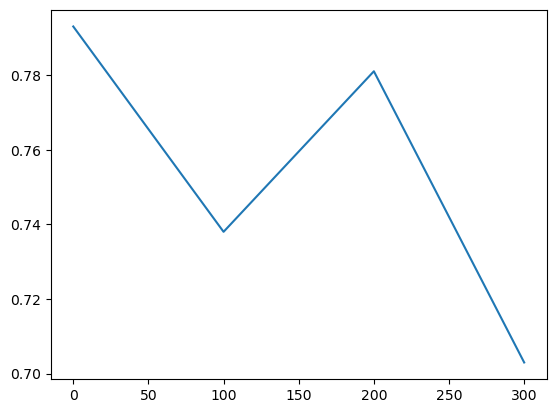

In [ ]:
# import matplotlib.pyplot as plt

# eps = [100*i for i in range(0,4)]

# plt.plot(eps, losses)

In [9]:
def get_predictions(X_val, model, threshold=0.5):
    sig = nn.Sigmoid() 
    yhat = sig(model(X_val)).detach().numpy()
    y_pred = yhat > threshold
    
    return y_pred

# y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
# # print(y_pred)

# # Create a DataFrame to save to CSV
# val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
# # val_data_with_pred['True_Label'] = y_test
# # val_data_with_pred['Predictions'] = dummy_predictions

# val_data_with_pred = val_data_with_pred.astype(int)

# val_data_with_pred['id'] = val['id']

# val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# # Save to CSV
# current_time = datetime.datetime.now()
# formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

# val_data_with_pred.to_csv(f'../results/pred_eng_a_{formatted_time}.csv', index=False)

# print(val_data_with_pred)

In [ ]:
# # DO 10 different prediction files with epochs 100, 200, 300, 400, 500, 600, 700, 800, 900 and 1000 Model parameters

# # Get 10 differen prediction files

# for i in range(4):
#     epoch = i*100
#     model.load_state_dict(torch.load(f'./23-12-24/net_epoch_{epoch}.pth', weights_only=True))
#     y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
#     # print(y_pred)

#     # Create a DataFrame to save to CSV
#     val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
#     # val_data_with_pred['True_Label'] = y_test
#     # val_data_with_pred['Predictions'] = dummy_predictions

#     val_data_with_pred = val_data_with_pred.astype(int)

#     val_data_with_pred['id'] = val['id']

#     val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

#     # Save to CSV
#     current_time = datetime.datetime.now()
#     formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

#     val_data_with_pred.to_csv(f'../results/alt4_3/alt4_epoch_{epoch}_pred_eng_a_{formatted_time}.csv', index=False)

#     print(val_data_with_pred)

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 0.weight: copying a param with shape torch.Size([128, 5252]) from checkpoint, the shape in current model is torch.Size([128, 5254]).

In [11]:
# DO 10 different prediction files with epochs 100, 200, 300, 400, 500, 600, 700, 800, 900 and 1000 Model parameters

# Get 10 differen prediction files

model.load_state_dict(torch.load(f'./24-12-24/net_epoch_200.pth', weights_only=True))
y_pred = get_predictions(torch.Tensor(final_val_features), model, 0.45)
# print(y_pred)

# Create a DataFrame to save to CSV
val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
# val_data_with_pred['True_Label'] = y_test
# val_data_with_pred['Predictions'] = dummy_predictions

val_data_with_pred = val_data_with_pred.astype(int)

val_data_with_pred['id'] = val['id']

val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# Save to CSV
current_time = datetime.datetime.now()
formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

val_data_with_pred.to_csv(f'../results/alt4_3/alt4_epoch_{epoch}_pred_eng_a_{formatted_time}.csv', index=False)

print(val_data_with_pred)

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.weight", "0.bias", "1.weight", "1.bias", "1.running_mean", "1.running_var", "4.weight", "4.bias", "6.weight", "6.bias". 
	Unexpected key(s) in state_dict: "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "fc.0.weight", "fc.0.bias", "fc.1.weight", "fc.1.bias", "fc.1.running_mean", "fc.1.running_var", "fc.1.num_batches_tracked", "fc.4.weight", "fc.4.bias", "fc.6.weight", "fc.6.bias". 

---

1. For Submission 5 files:

    Your results for eng track A are:

    Multi-label accuracy (Jaccard score): 0.26063218390804593

    Micro F1 score: 0.41758241758241754

    Macro F1 score: 0.36549662349391404

2. For Submission 6 files:

    Your results for eng track A are:

    Multi-label accuracy (Jaccard score): 0.26206896551724135

    Micro F1 score: 0.42659279778393355

    Macro F1 score: 0.36911780259117266

3. For Submission 8 files

| Epoch | Jaccard Index       | Micro F1            | Macro F1            |
| ----- | ------------------- | ------------------- | ------------------- |
| 0     | 0.29094827586206906 | 0.4409171075837742  | 0.3952511404048909  |
| 100   | 0.24080459770114943 | 0.39560439560439564 | 0.3420526643168152  |
| 200   | 0.2548850574712644  | 0.4089635854341737  | 0.3569574389199279  |
| 300   | 0.2548850574712644  | 0.41758241758241754 | 0.3576650885346538  |
| 400   | 0.2557471264367816  | 0.4098360655737705  | 0.3598377304037682  |
| 500   | 0.2530172413793103  | 0.41666666666666663 | 0.35474739097380603 |
| 600   | 0.26379310344827583 | 0.41208791208791207 | 0.3499361424130125  |
| 700   | 0.27241379310344827 | 0.42622950819672134 | 0.37301587301587297 |
| 800   | 0.253448275862069   | 0.4098360655737705  | 0.3496649512518185  |
| 900   | 0.25804597701149423 | 0.41961852861035426 | 0.37158938378169115 |